# Building a Recommender System for Anime Series

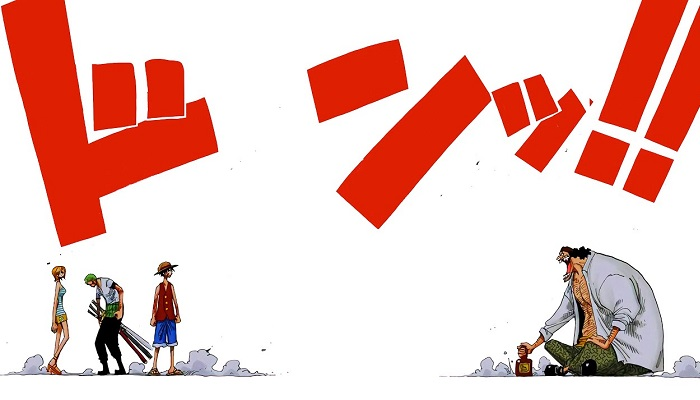

## Introduction

<b>Recommender systems</b> are widely used in e-commerce and entertainment platforms such as Amazon and Netflix, and their main purpose is to introduce users to different products or media that will most probably be of interest to them. Think along the lines of:

> <i>Customers who bought this item also bought:</i>
>
> <i>Because you watched Brooklyn Nine-Nine, you will enjoy:</i>

As users are introduced to new items that entice them, they will be more likely to make an additional purchase, thus driving up sales for the e-commerce platforms. Likewise, they will spend more time on entertainment platforms such as Spotify or YouTube and potentially increase the ad revenue for these companies.

In this notebook, we will attempt to build a recommender system that will introduce me to exciting new animes based on my historical preference. We will use both memory-based and model-based collaborative filtering methods.

## Data

The dataset of approximately 73,000 users' anime ratings was obtained from: https://www.kaggle.com/CooperUnion/anime-recommendations-database/

> <i>This data set contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings. Thanks to myanimelist.net API for providing anime data and user ratings.</i>

In order to introduce new animes based on my historical preference, I will also need a separate dataset detailing my ratings for the animes that I have previously watched.

## Table of Contents

1. [Import libraries and data](#head-1)  
2. [Exploratory data analysis](#head-2)  
3. [Data manipulation](#head-3)  
4. [Memory-based collaborative filtering](#head-4)  
5. [Model-based collaborative filtering](#head-5)  

# 1. Import libraries and data <a class="anchor" id="head-1"></a>

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import GridSearchCV, cross_validate
from collections import defaultdict

anime  = pd.read_csv("anime.csv")
rating = pd.read_csv("rating.csv")
alvin  = pd.read_csv("alvin.csv")

In [2]:
# Concatenating my ratings to the main rating file.
alvin = alvin[['anime_id', 'rating_alvin']][alvin['rating_alvin'].notnull()]
alvin['user_id'] = rating.user_id.max() + 1     # 73,517
alvin = alvin.rename(columns={'rating_alvin': 'rating'})
alvin = alvin[['user_id', 'anime_id', 'rating']]
rating = pd.concat([rating, alvin])

rating

,user_id,anime_id,rating
0,1,20,-1.0
1,1,24,-1.0
2,1,79,-1.0
3,1,226,-1.0
4,1,241,-1.0
...,...,...,...
1389,73517,28,9.0
2097,73517,966,8.0
2813,73517,34096,3.0
3040,73517,21899,3.0


# 2. Exploratory data analysis <a class="anchor" id="head-2"></a>

In [3]:
# These are the top 10 highest-rated animes with at least 100,000 viewers.
highest_rated = anime[(anime['members'] > 100000) & (anime['type'] == 'TV')]
highest_rated.sort_values(by='rating', ascending=False, inplace=True)

highest_rated[['name', 'rating', 'members']].head(10).reset_index(drop=True)

,name,rating,members
0,Fullmetal Alchemist: Brotherhood,9.26,793665
1,Gintama°,9.25,114262
2,Steins;Gate,9.17,673572
3,Gintama&#039;,9.16,151266
4,Hunter x Hunter (2011),9.13,425855
5,Clannad: After Story,9.06,456749
6,Gintama,9.04,336376
7,Code Geass: Hangyaku no Lelouch R2,8.98,572888
8,Haikyuu!! Second Season,8.93,179342
9,Shigatsu wa Kimi no Uso,8.92,416397


In [4]:
# These are the top 10 most popular animes in terms of number of viewers.
most_popular = anime[anime['type'] == 'TV']
most_popular.sort_values(by='members', ascending=False, inplace=True)

most_popular[['name', 'rating', 'members']].head(10).reset_index(drop=True)

,name,rating,members
0,Death Note,8.71,1013917
1,Shingeki no Kyojin,8.54,896229
2,Sword Art Online,7.83,893100
3,Fullmetal Alchemist: Brotherhood,9.26,793665
4,Angel Beats!,8.39,717796
5,Code Geass: Hangyaku no Lelouch,8.83,715151
6,Naruto,7.81,683297
7,Steins;Gate,9.17,673572
8,Mirai Nikki (TV),8.07,657190
9,Toradora!,8.45,633817


# 3. Data manipulation <a class="anchor" id="head-3"></a>

First, we will perform some data cleaning by only selecting positive ratings as well as TV and movie animes. Also, we will only select animes that have been rated by at least 100 users, and users that have given at least 100 ratings.

After that, we will generate a sparse matrix by pivoting the data (each row will represent a user and each column will represent an anime) such that the cosine similarities can be computed between each anime pair or user pair. Lastly, we will normalise the data to minimise user bias.

In [5]:
rating_merged = rating.merge(anime[['anime_id', 'name', 'type']], on='anime_id', how='left')
rating_merged = rating_merged[rating_merged['rating'] != -1]
rating_merged = rating_merged[(rating_merged['type'] == 'TV') | (rating_merged['type'] == 'Movie')]

user_count  = rating_merged['user_id'].value_counts()
anime_count = rating_merged['anime_id'].value_counts()

rating_merged = rating_merged[rating_merged['user_id'].isin(user_count[user_count >= 100].index)]
rating_merged = rating_merged[rating_merged['anime_id'].isin(anime_count[anime_count >= 100].index)]

rating_merged

,user_id,anime_id,rating,name,type
302,5,6,8.0,Trigun,TV
303,5,15,6.0,Eyeshield 21,TV
304,5,17,6.0,Hungry Heart: Wild Striker,TV
305,5,18,6.0,Initial D Fourth Stage,TV
306,5,20,6.0,Naruto,TV
...,...,...,...,...,...
7813862,73517,2986,7.0,Bamboo Blade,TV
7813863,73517,80,5.0,Mobile Suit Gundam,TV
7813864,73517,7472,3.0,Gintama Movie: Shinyaku Benizakura-hen,Movie
7813865,73517,28,9.0,Yakitate!! Japan,TV


In [6]:
rating_pivot = rating_merged.pivot_table(index   = 'user_id',
                                         columns = 'name',
                                         values  = 'rating')
rating_pivot_norm = rating_pivot.apply(lambda x: (x - np.mean(x)), axis=1)
rating_pivot_norm.fillna(0, inplace=True)

rating_pivot_norm

name,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Trilogy,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//The Movie: Sekai no Mukou ni,009 Re:Cyborg,009-1,07-Ghost,1001 Nights,...,"Zone of the Enders: Dolores, I",Zutto Mae kara Suki deshita.: Kokuhaku Jikkou Iinkai,eX-Driver the Movie,ef: A Tale of Melodies.,ef: A Tale of Memories.,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-2.439437,0.000000,0.000000
7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
14,0.798165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
17,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.997207,0.0,0.000000,0.000000,0.000000,0.000000
21,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73503,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.591111,1.591111,0.000000
73507,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.732143,0.732143,0.732143
73510,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [7]:
rating_sparse = csr_matrix(rating_pivot_norm.values)

user_similarity = cosine_similarity(rating_sparse)
user_similarity = pd.DataFrame(user_similarity, index=rating_pivot_norm.index, columns=rating_pivot_norm.index)

item_similarity = cosine_similarity(rating_sparse.T)
item_similarity = pd.DataFrame(item_similarity, index=rating_pivot_norm.columns, columns=rating_pivot_norm.columns)

# 4. Memory-based collaborative filtering <a class="anchor" id="head-4"></a>

In <b>memory-based collaborative filtering</b>, we will look for the most similar animes or users based on the <b>[cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)</b> metric. Two functions are defined below:

* <b>top_similar_animes</b>: Generates a list of top 10 most similar animes to any given anime
* <b>top_recommendations_by_similar_users</b>: Generates a list of top 10 recommended animes to any user by searching for similar users and returning their top preferences

In [8]:
# These are the top 10 animes most similar to One Punch Man.
def top_similar_animes(name, top_j_recommendations):
    similar_anime = pd.DataFrame(item_similarity.loc[name].sort_values(ascending=False))
    similar_anime.reset_index(inplace=True)
    similar_anime.columns = ['name', 'similarity']
    similar_anime = similar_anime[~similar_anime['name'].str.contains(name)]
    
    return similar_anime.head(top_j_recommendations)

top_similar_animes('One Punch Man', 10)

,name,similarity
1,Fullmetal Alchemist: Brotherhood,0.424980
2,Steins;Gate,0.422475
3,Shokugeki no Souma,0.412809
4,Kiseijuu: Sei no Kakuritsu,0.408926
5,Hunter x Hunter (2011),0.399436
6,Boku dake ga Inai Machi,0.391136
7,Boku no Hero Academia,0.384516
8,Mob Psycho 100,0.380311
9,Shingeki no Kyojin,0.379417
10,Re:Zero kara Hajimeru Isekai Seikatsu,0.354300


In [9]:
# These are the top 10 recommended animes for me based on the preferences of other users similar to me.
def top_recommendations_by_similar_users(user, top_k_similar_users, top_j_recommendations):
    
    if user not in user_similarity.index:
        return('User {} is not applicable.'.format(user))
    
    similar_users = pd.DataFrame(user_similarity.loc[user].sort_values(ascending=False))
    similar_users.reset_index(inplace=True)
    similar_users.columns = ['user', 'similarity']
    similar_users = similar_users[similar_users['user'] != user].head(top_k_similar_users)
    
    anime_list = []
    
    for i in similar_users['user'].tolist():
        max_score = rating_pivot_norm.loc[i].max()
        top_list  = rating_pivot_norm.loc[i]
        for j in top_list[top_list == max_score].index.tolist():
            anime_list.append(j)
    
    watched = rating[rating['user_id'] == user].merge(anime[['anime_id', 'name']], on='anime_id', how='left')
    
    top_recommendations = Counter(anime_list)
    top_recommendations = pd.DataFrame(top_recommendations, index=[0]).T.reset_index()
    top_recommendations.columns = ['name', 'popularity']
    top_recommendations = top_recommendations[~top_recommendations['name'].isin(watched['name'])]
    top_recommendations.sort_values(by='popularity', ascending=False, inplace=True, ignore_index=True)
    
    return top_recommendations.head(top_j_recommendations)

top_recommendations_by_similar_users(73517, 100, 10)

,name,popularity
0,Angel Beats!,15
1,Great Teacher Onizuka,10
2,Dragon Ball Z,10
3,Mononoke Hime,8
4,Kimi ni Todoke,8
5,Kimi ni Todoke 2nd Season,7
6,Kotonoha no Niwa,7
7,Tokyo Ghoul √A,7
8,Dragon Ball,7
9,Death Parade,7


# 5. Model-based collaborative filtering <a class="anchor" id="head-5"></a>

<b>Model-based collaborative filtering</b> is another kind of algorithm for building recommender systems, where we will train a model based on supervised learning to predict the users' ratings on new animes.

The <b>[Surprise](https://surprise.readthedocs.io/en/stable/FAQ.html)</b> library is used below.

In [10]:
reader = Reader(rating_scale=(1, 10))

svd_data = Dataset.load_from_df(rating_merged[['user_id', 'name', 'rating']], reader)

In [16]:
# Hyperparameter tuning
svd_param_grid = {
    'n_factors': [10, 20],
    'n_epochs' : [5, 10],
    'lr_all'   : [0.002, 0.005],
    'reg_all'  : [0.4, 0.6]
}

svd_gridsearch_model = GridSearchCV(algo_class     = SVD,
                                    param_grid     = svd_param_grid,
                                    cv             = 3,
                                    n_jobs         = -1,
                                    joblib_verbose = 2)

svd_gridsearch_model.fit(svd_data)

print(svd_gridsearch_model.best_score['rmse'])
print(svd_gridsearch_model.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 42.5min


1.1997049005495504
{'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 58.7min finished


In [11]:
trainset = svd_data.build_full_trainset()
testset  = trainset.build_anti_testset()
print('Number of Users : ', trainset.n_users, '\n')
print('Number of Animes: ', trainset.n_items, '\n')

algo = SVD()
algo.fit(trainset)

predictions = algo.test(testset)

Number of Users :  17019 

Number of Animes:  2489 



In [12]:
# These are the top 10 recommended animes for me using model-based collaborative filtering.
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=10)

top_n[73517]

[('Free!', 9.940367747306865),
 ('Oban Star-Racers', 9.83551211425313),
 ('Boruto: Naruto the Movie', 9.783000842057312),
 ('Tonari no Totoro', 9.649632605720058),
 ('Naruto: Shippuuden Movie 2 - Kizuna', 9.539240190257761),
 ('Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono', 9.465638952152878),
 ('Tenjou Tenge: The Past Chapter', 9.448253463689495),
 ('Tenjou Tenge', 9.242454992552267),
 ('Digimon Adventure: Bokura no War Game!', 9.154593089266326),
 ('Ouran Koukou Host Club', 9.150358673108768)]

In [13]:
cv_results = cross_validate(algo     = algo,
                            data     = svd_data,
                            measures = ['RMSE'],
                            cv       = 3,
                            return_train_measures = True
                           )

cv_results['test_rmse'].mean()

1.1007828190469129